# Tutorial

This tutorial shows the basic steps of using SEP to detect objects in an image and perform some basic aperture photometry.

Here, we use the `fitsio` package, just to read the test image, but you can also use `astropy.io.fits` for this purpose (or any other FITS reader).

In [48]:
import numpy as np
import sep

I changed fitsio package import for astropy.io fits package.

In [49]:
# additional setup for reading the test image and displaying plots
# import fitsio
from astropy.io import fits

import matplotlib.pyplot as plt
from matplotlib import rcParams

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

First, we'll read an example image from a FITS file and display it, just to show what we're dealing with. The example image is just 256 x 256 pixels.
I changed reading the data file using astropy package format which contains header and data fields separately.


In [106]:
# read image into standard 2-d numpy array
# data = fitsio.read("../data/image.fits")
hdulist = fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits')
primary_hdu = hdulist[0]  # Access the first HDU
data = primary_hdu.data   # Access the data
data = data.byteswap(inplace=True).newbyteorder()
header = primary_hdu.header  # Access the header
hdulist.close()


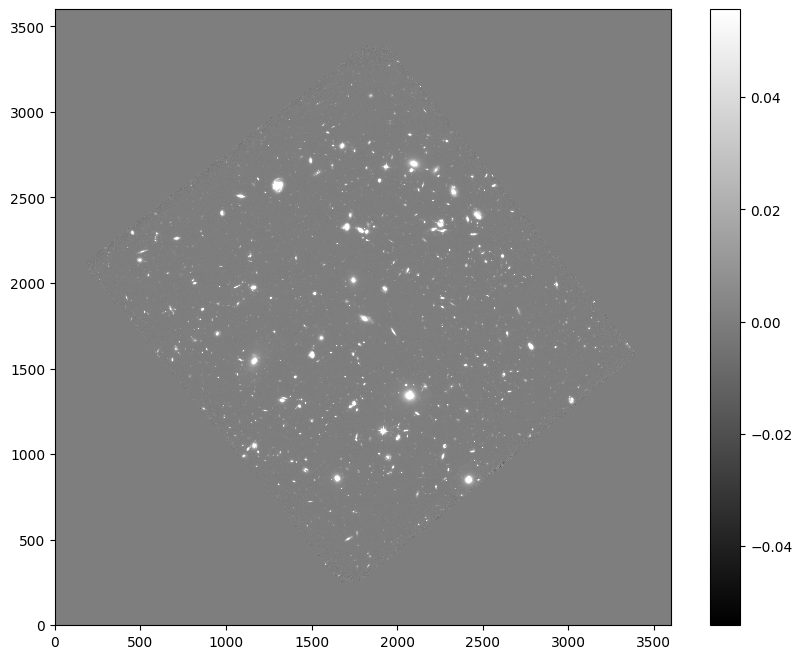

In [107]:
# show the image
m, s = np.mean(data), np.std(data)
plt.imshow(data, interpolation='nearest', cmap='gray', vmin=m-s, vmax=m+s, origin='lower')
plt.colorbar();
plt.savefig('part2_image1.png', bbox_inches='tight', dpi=400)

## Background subtraction

Most optical/IR data must be background subtracted before sources can be detected. In SEP, background estimation and source detection are two separate steps.

In [55]:
# measure a spatially varying background on the image
bkg = sep.Background(data)

There are various options for controlling the box size used in estimating the background. It is also possible to mask pixels. For example:
```python
bkg = sep.Background(data, mask=mask, bw=64, bh=64, fw=3, fh=3)
```
See the reference section for descriptions of these parameters.

This returns an `Background` object that holds information on the spatially varying background and spatially varying background noise level.  We can now do various things with this `Background` object:

In [56]:
# get a "global" mean and noise of the image background:
print(bkg.globalback)
print(bkg.globalrms)

0.0
0.0005398219218477607


In [57]:
# evaluate background as 2-d array, same size as original image
bkg_image = bkg.back()
# bkg_image = np.array(bkg) # equivalent to above

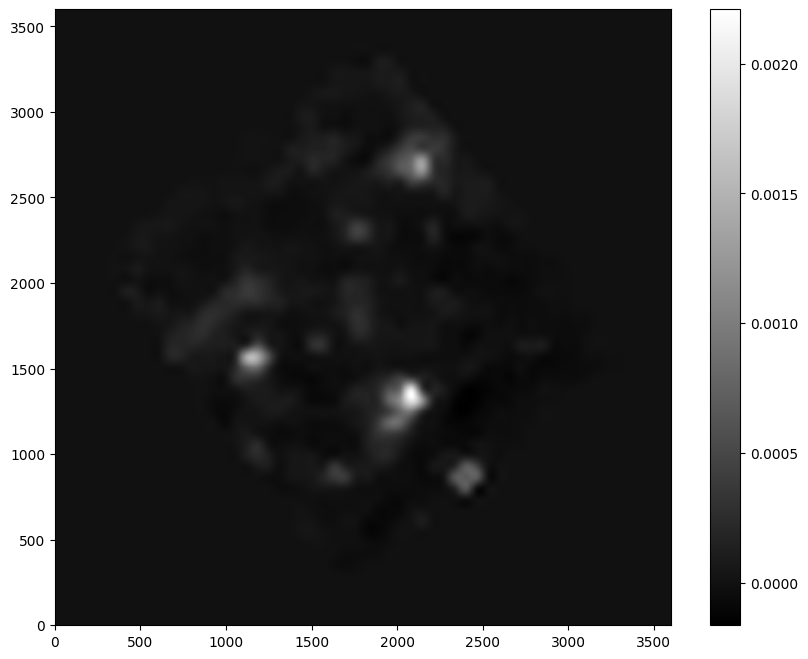

In [58]:
# show the background
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('part2_image2.png', bbox_inches='tight', dpi=400)

In [59]:
# evaluate the background noise as 2-d array, same size as original image
bkg_rms = bkg.rms()

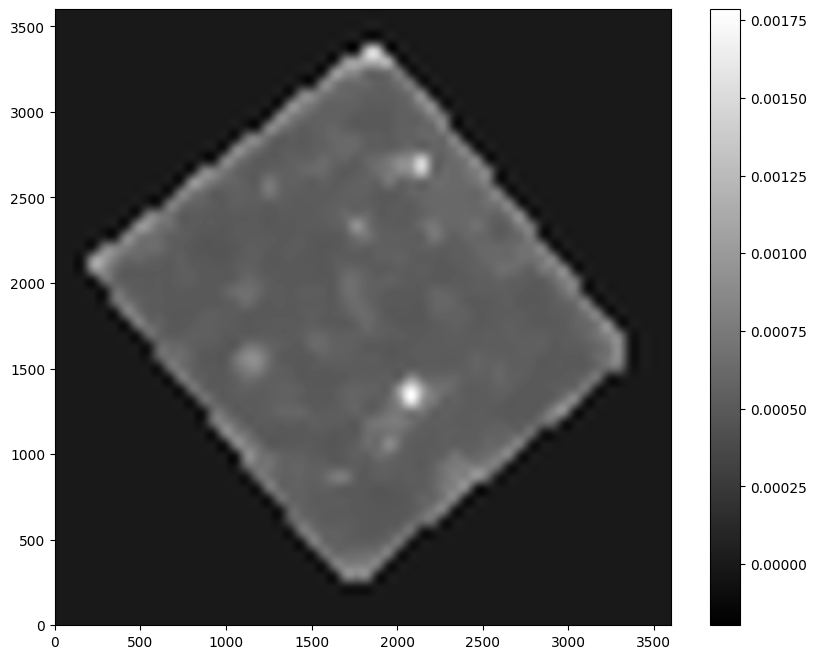

In [60]:
# show the background noise
plt.imshow(bkg_rms, interpolation='nearest', cmap='gray', origin='lower')
plt.colorbar();
plt.savefig('part2_image3.png', bbox_inches='tight', dpi=400)

In [61]:
# subtract the background
data_sub = data - bkg


One can also subtract the background from the data array in-place by doing `bkg.subfrom(data)`.

<div class="alert alert-warning">

**Warning:**

If the data array is not background-subtracted or the threshold is too low, you will tend to get one giant object when you run object detection using `sep.extract`. Or, more likely, an exception will be raised due to exceeding the internal memory constraints of the `sep.extract` function.
</div>

## Object detection

Now that we've subtracted the background, we can run object detection on the background-subtracted data. You can see the background noise level is pretty flat. So here we're setting the detection threshold to be a constant value of $1.5 \sigma$ where $\sigma$ is the global background RMS.

In [62]:
objects = sep.extract(data_sub, 1.5, err=bkg.globalrms)

`sep.extract` has many options for controlling detection threshold, pixel masking, filtering, and object deblending. See the reference documentation for details.

`objects` is a NumPy structured array with many fields.

In [63]:
# how many objects were detected
len(objects)

8640

`objects['x']` and `objects['y']` will give the centroid coordinates of the objects. Just to check where the detected objects are, we'll over-plot the object coordinates with some basic shape parameters on the image:

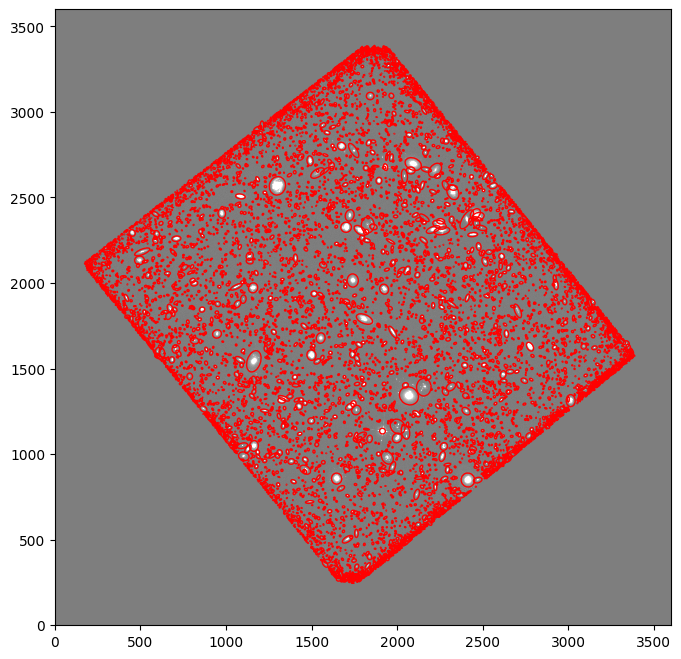

In [64]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for each object
for i in range(len(objects)):
    e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
                width=6*objects['a'][i],
                height=6*objects['b'][i],
                angle=objects['theta'][i] * 180. / np.pi)
    e.set_facecolor('none')
    e.set_edgecolor('red')
    ax.add_artist(e)
plt.savefig('part2_image4.png', bbox_inches='tight', dpi=400)

`objects` has many other fields, giving information such as second moments, and peak pixel positions and values. See the reference documentation for `sep.extract` for descriptions of these fields. You can see the available fields:

In [65]:
# available fields
objects.dtype.names

('thresh',
 'npix',
 'tnpix',
 'xmin',
 'xmax',
 'ymin',
 'ymax',
 'x',
 'y',
 'x2',
 'y2',
 'xy',
 'errx2',
 'erry2',
 'errxy',
 'a',
 'b',
 'theta',
 'cxx',
 'cyy',
 'cxy',
 'cflux',
 'flux',
 'cpeak',
 'peak',
 'xcpeak',
 'ycpeak',
 'xpeak',
 'ypeak',
 'flag')

## Aperture photometry

Finally, we'll perform simple circular aperture photometry with a 3 pixel radius at the locations of the objects:

In [66]:
flux, fluxerr, flag = sep.sum_circle(data_sub, objects['x'], objects['y'],
                                     3.0, err=bkg.globalrms, gain=1.0)

`flux`, `fluxerr` and `flag` are all 1-d arrays with one entry per object.

In [45]:
# show the first 10 objects results:
for i in range(20):
    print("object {:d}: flux = {:f} +/- {:f}".format(i, flux[i], fluxerr[i]))

object 0: flux = 0.031282 +/- 0.176890
object 1: flux = 0.031018 +/- 0.176142
object 2: flux = -0.024388 +/- 0.002883
object 3: flux = 0.001947 +/- 0.044219
object 4: flux = 0.012457 +/- 0.111649
object 5: flux = -0.011228 +/- 0.002875
object 6: flux = 0.029368 +/- 0.171394
object 7: flux = -0.009126 +/- 0.002875
object 8: flux = 0.048023 +/- 0.219161
object 9: flux = 0.027840 +/- 0.166877
object 10: flux = 0.104682 +/- 0.323559
object 11: flux = 0.044953 +/- 0.212041
object 12: flux = 0.014043 +/- 0.118538
object 13: flux = 0.010265 +/- 0.101357
object 14: flux = 0.011400 +/- 0.106811
object 15: flux = 0.025562 +/- 0.159908
object 16: flux = 0.016498 +/- 0.128478
object 17: flux = -0.008420 +/- 0.002875
object 18: flux = 0.006981 +/- 0.083599
object 19: flux = 0.014791 +/- 0.121653


In [46]:
print(flux)

[ 0.03128197  0.03101789 -0.02438809 ...  0.08851303  0.01802793
  0.01398957]


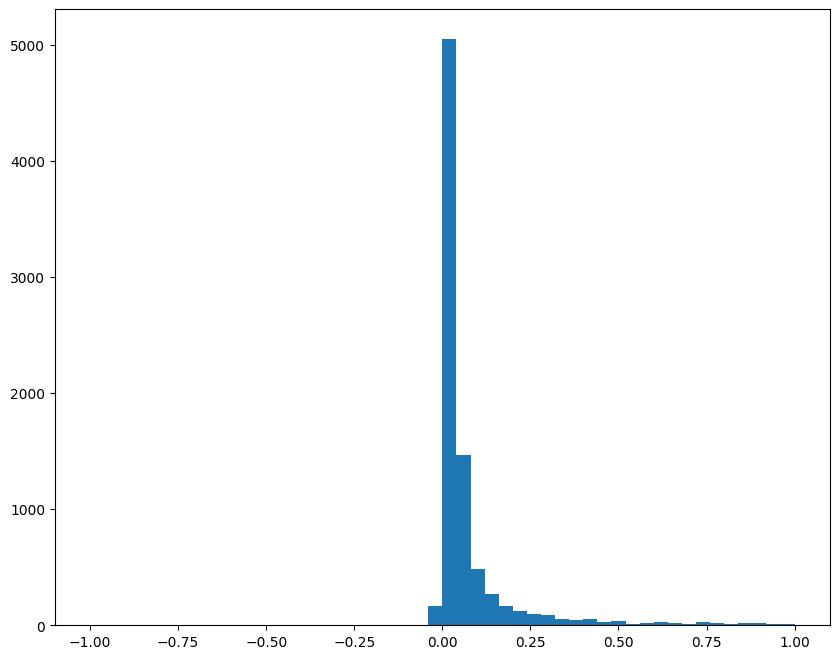

In [80]:
plt.hist(flux, range = (-1.0, 1.0), bins = 50)
plt.savefig('part2_image5.png', bbox_inches='tight', dpi=400)

In [76]:
mean = np.mean(flux)
print("Mean:", mean)
median = np.median(flux)
print("Median:", median)
std_dev = np.std(flux)
print("Standard Deviation:", std_dev)


Mean: 0.36186200072018937
Median: 0.03095655805023853
Standard Deviation: 9.24352784277779


In [97]:
# Find the index of the largest outlier
outlier_index = np.argmax(flux)

# Largest Outlier
largest_outlier = flux[outlier_index]

print("Largest Outlier index:", outlier_index)
print("Largest Outlier:", largest_outlier)

print(f"Number of std from the mean for the largest outlier: {(largest_outlier - mean) / std_dev}")

Largest Outlier index: 2066
Largest Outlier: 807.2972835731507
Number of std from the mean for the largest outlier: 87.29734310292692


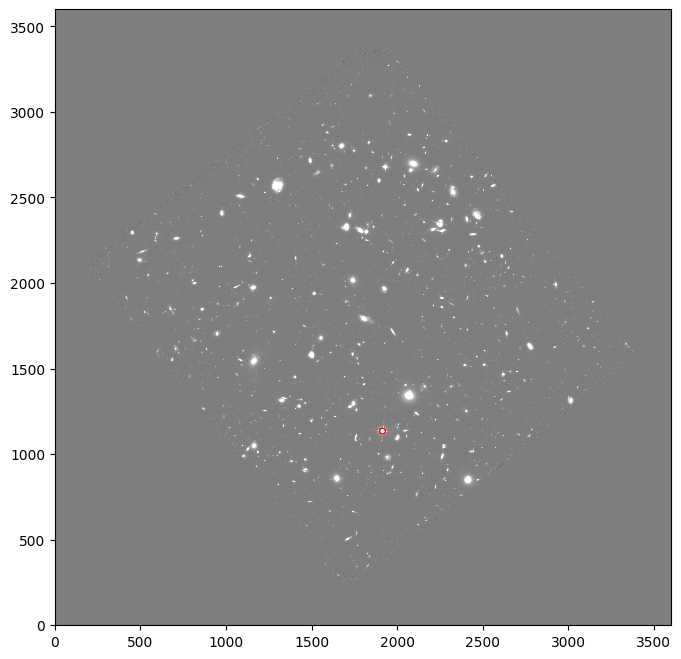

In [92]:
from matplotlib.patches import Ellipse

# plot background-subtracted image
fig, ax = plt.subplots()
m, s = np.mean(data_sub), np.std(data_sub)
im = ax.imshow(data_sub, interpolation='nearest', cmap='gray',
               vmin=m-s, vmax=m+s, origin='lower')

# plot an ellipse for largest outlier 
i = outlier_index
e = Ellipse(xy=(objects['x'][i], objects['y'][i]),
            width=6*objects['a'][i],
            height=6*objects['b'][i],
            angle=objects['theta'][i] * 180. / np.pi)
e.set_facecolor('none')
e.set_edgecolor('red')
ax.add_artist(e)
plt.savefig('part2_image6.png', bbox_inches='tight', dpi=400)

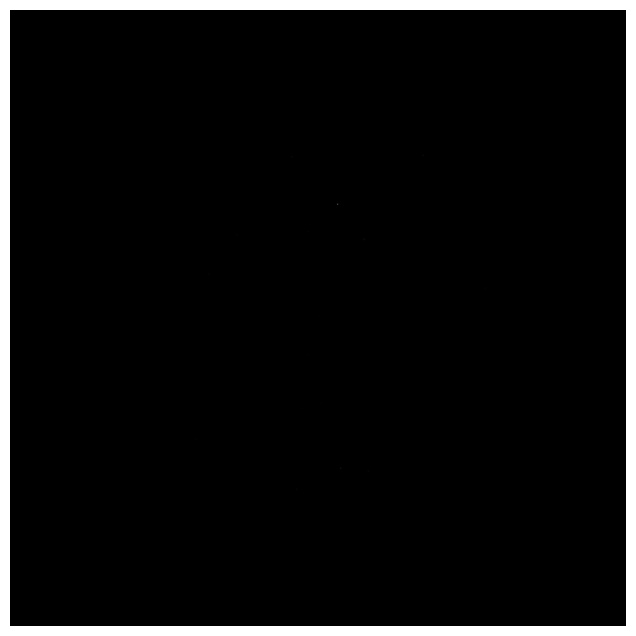

In [111]:

# Load data from each FITS file
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdul:
    data1 = hdul[0].data
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits') as hdul:
    data2 = hdul[0].data
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits') as hdul:
    data3 = hdul[0].data

# Normalize the data (simple normalization to 0-1 range)
data1_normalized = data1 / np.max(data1)
data2_normalized = data2 / np.max(data2)
data3_normalized = data3 / np.max(data3)

# Stack the data into an RGB image
rgb_image = np.stack((data1_normalized, data2_normalized, data3_normalized), axis=-1)

# Ensure no values are outside the [0, 1] range
rgb_image = np.clip(rgb_image, 0, 1)

# Display the image
plt.imshow(rgb_image)
plt.axis('off')  # Turn off axis numbers
# plt.show()
plt.savefig('part2_image7.png', bbox_inches='tight', dpi=400)

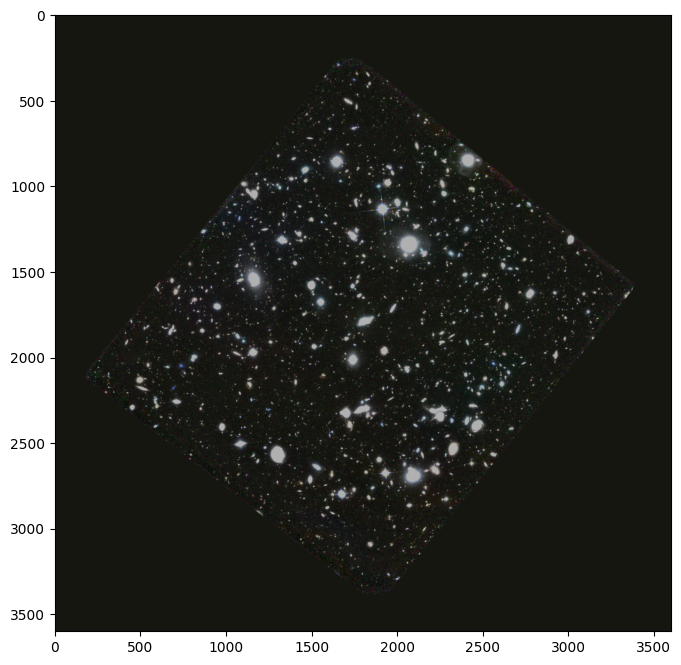

In [115]:
def normalize_data(data, lower_percentile=1, upper_percentile=99):
    """Normalize data using percentiles to enhance contrast."""
    min_val = np.percentile(data, lower_percentile)
    max_val = np.percentile(data, upper_percentile)
    return np.clip((data - min_val) / (max_val - min_val), 0, 1)

def logarithmic_scale(data):
    """Apply logarithmic scaling to enhance contrast."""
    return np.log1p(data - data.min())

# Load data from each FITS file
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f105w_v1.0_drz.fits') as hdul:
    data1 = hdul[0].data
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f125w_v1.0_drz.fits') as hdul:
    data2 = hdul[0].data
with fits.open('hlsp_hudf12_hst_wfc3ir_udfmain_f160w_v1.0_drz.fits') as hdul:
    data3 = hdul[0].data

# Normalize the data using percentiles
data1_normalized = logarithmic_scale(normalize_data(data1))
data2_normalized = logarithmic_scale(normalize_data(data2))
data3_normalized = logarithmic_scale(normalize_data(data3))

# Stack the data into an RGB image
rgb_image = np.stack((data1_normalized, data2_normalized, data3_normalized), axis=-1)

# Display the image
plt.imshow(rgb_image)
plt.savefig('part2_image7.png', bbox_inches='tight', dpi=400)

## Finally a brief word on byte order

<div class="alert alert-info">

**Note:**

If you are using SEP to analyze data read from FITS files with
[astropy.io.fits](http://astropy.readthedocs.org/en/stable/io/fits/)
you may see an error message such as:

```
ValueError: Input array with dtype '>f4' has non-native byte order.
Only native byte order arrays are supported. To change the byte
order of the array 'data', do 'data = data.byteswap().newbyteorder()'
```

It is usually easiest to do this byte-swap operation directly after
reading the array from the FITS file. You can even perform the byte
swap in-place by doing

```python
>>> data = data.byteswap(inplace=True).newbyteorder()
```

If you do this in-place operation, ensure that there are no other
references to ``data``, as they will be rendered nonsensical.

For the interested reader, this byteswap operation is necessary because
astropy.io.fits always returns big-endian byte order arrays, even on
little-endian machines. For more on this, see
</div>